<div style="display: flex; background-color: RGB(26,39,55);" >
<h1 style="margin: auto; padding: 30px; color:white;">Détection de Faux billets</h1>
</div>

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement du fichier</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Importation des librairies standards</h3>
</div>

In [1]:
#importation des Librairies standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from math import sqrt
from scipy import stats

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargement et analyse du dataset</h3>
</div>

In [2]:
df=pd.read_csv("billets.csv", sep=";")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
#Identification de valeur nulles"
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [5]:
df_final=df.copy()

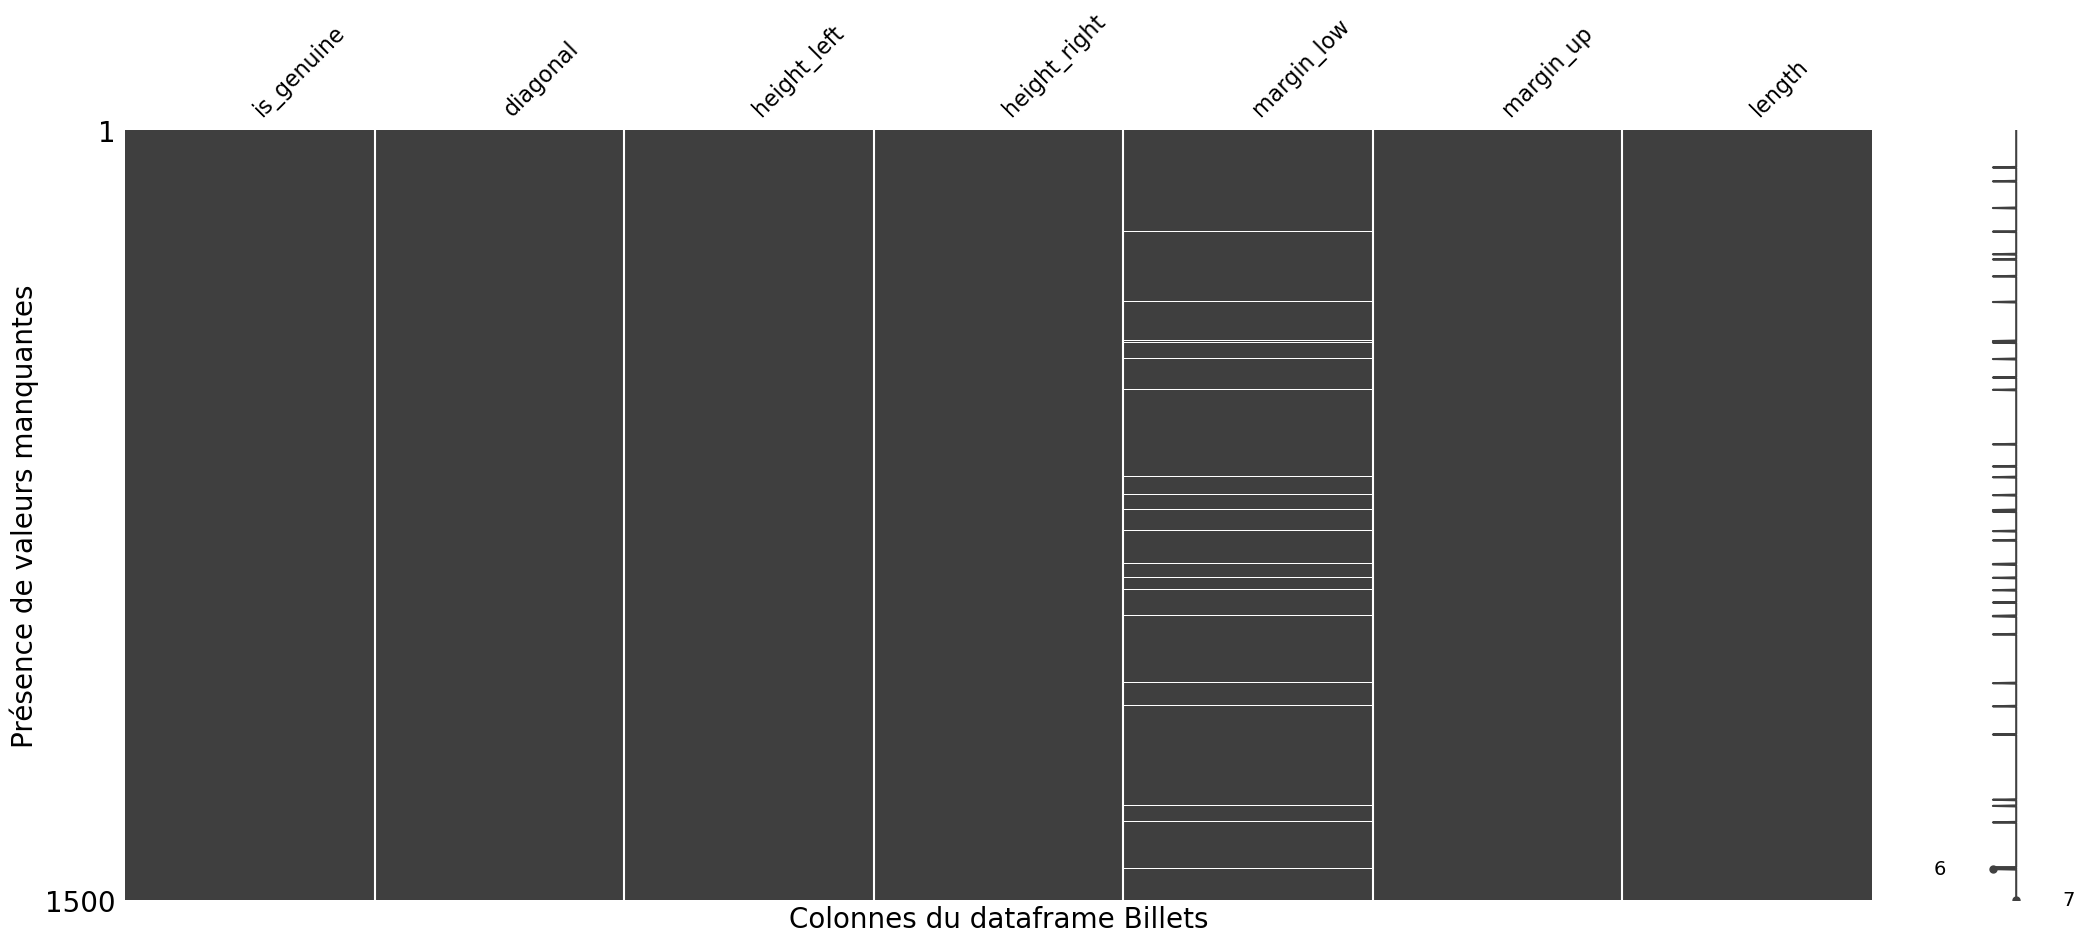

In [6]:
#contrôle du positionnement des NaN avec missingno
msno.matrix(df)
plt.xlabel("Colonnes du dataframe Billets",size=20)
plt.ylabel("Présence de valeurs manquantes",size=20)
plt.show()

In [7]:
#Identification des données
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [8]:
#Vérification si présence de doublon (sinon df.drop_duplicates(inplace=True))
df.duplicated().sum()

0

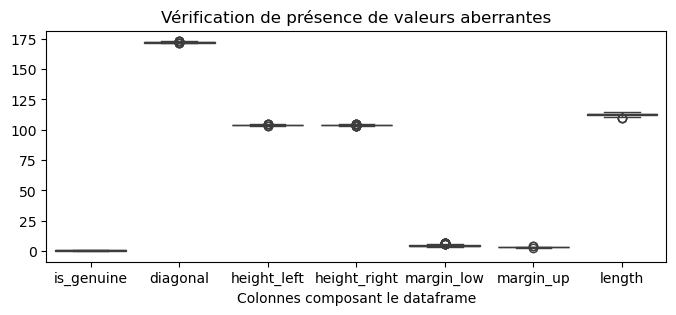

In [9]:
#Identification de valeurs abérrentes
plt.figure(figsize=(8,3))
sns.boxplot(df)
plt.title("Vérification de présence de valeurs aberrantes")
plt.xlabel("Colonnes composant le dataframe")
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Mise en place de la regression lineaire pour déterminer les valeurs manquantes</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Préparation des données pour test de régression linéaire</h3>
</div>

In [10]:
#Importation des bibliothèques
from sklearn.linear_model import LinearRegression # modèle de régression linéaire
from sklearn.preprocessing import OneHotEncoder #Séparation des données is geniune en colonne
from sklearn.model_selection import cross_val_score # Faire une cross validation
from sklearn.model_selection import train_test_split # Splitter le jeu de données

In [11]:
df.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16


<Axes: xlabel='is_genuine', ylabel='count'>

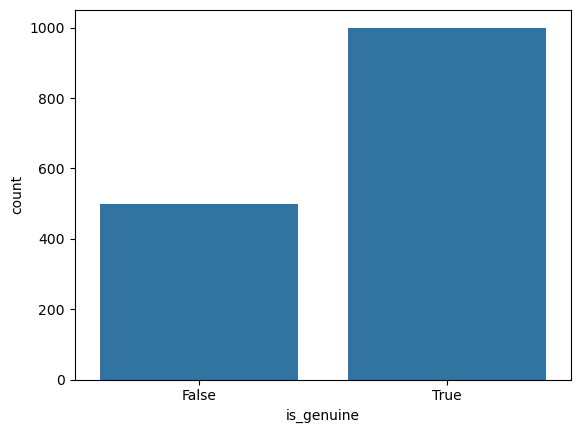

In [12]:
#Visualisation des écarts de valeurs entre les valeurs False et True de "is_genuine"
sns.countplot(data=df, x='is_genuine')

In [13]:
#Mise en colonne des valeurs de "is_genuine" avec le fonction OnehotEncoder
encoder=OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[["is_genuine"]]).toarray())

In [14]:
#Renommer les colonnes 0 et 1 en fake et true banknote
encoder_df.rename(columns={0 : 'Fake_BankNote', 1 : 'True_BankNote'}, inplace =True)

In [15]:
encoder_df.head(3)

,Fake_BankNote,True_BankNote
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0


In [16]:
#Création d'un DataFrame spécifique en concaténant df avec les valeurs Fake_bankNote et True_BankNote
df_margin_low=pd.concat([df, encoder_df], axis=1)

In [17]:
df_margin_low.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Fake_BankNote,True_BankNote
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0.0,1.0
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0.0,1.0
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0.0,1.0


In [18]:
#Retrait de la colonne is_genuine qui a été "hot encodée"
df_margin_low.drop(["is_genuine"],axis=1, inplace=True)

In [19]:
#Conservation d'une copie pour récup valeur
df_margin_low_NA=df_margin_low.copy()

In [20]:
df_margin_low_NA.shape

(1500, 8)

In [21]:
#Retrait des valeurs inconnues dans le DataFrame df_margin_low
df_margin_low.dropna(inplace=True)

In [22]:
df_margin_low.shape

(1463, 8)

In [23]:
#Mise en place des valeurs explicatives X et de cible y

In [24]:
X=df_margin_low[['diagonal',
 'height_left',
 'height_right',
 'margin_up',
 'length',
 'Fake_BankNote',
 'True_BankNote']]
#ajouter .values pour convertir en array

In [25]:
#y=df_margin_low.margin_low
y=df_margin_low.margin_low.values

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Test de Colinéarité des Variables</h3>
</div>

In [26]:
#Aperçu des corrélations entre variables
df_margin_low.corr()

,diagonal,height_left,height_right,margin_low,margin_up,length,Fake_BankNote,True_BankNote
diagonal,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758,-0.134720,0.134720
height_left,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344,0.373624,-0.373624
height_right,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272,0.487177,-0.487177
margin_low,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753,0.783032,-0.783032
margin_up,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139,0.610412,-0.610412
length,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000,-0.850223,0.850223
Fake_BankNote,-0.134720,0.373624,0.487177,0.783032,0.610412,-0.850223,1.000000,-1.000000
True_BankNote,0.134720,-0.373624,-0.487177,-0.783032,-0.610412,0.850223,-1.000000,1.000000


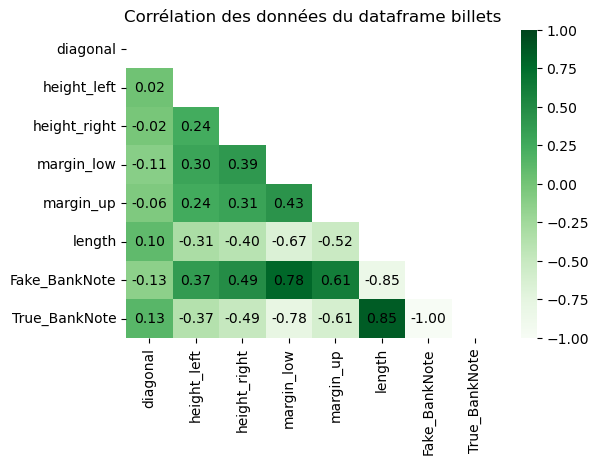

In [27]:
#Visualitation corrélation avec un graphique heatmap
fig, ax = plt.subplots(figsize=(6,4))
heatmap= sns.heatmap(df_margin_low.corr(), annot=True, fmt=".2f", cmap="Greens", vmin=-1, vmax=1, ax=ax, annot_kws={"color": "black"},  mask=np.triu(df_margin_low.corr()))
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.set_tick_params(color='black')
plt.setp(colorbar.ax.yaxis.get_majorticklabels(), color='black')
plt.title("Corrélation des données du dataframe billets",color='black')
plt.show()

In [28]:
#Test de colinéarité des variables pour identifier les corrélations fortes avec la bibliothèque VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [29]:
#Mise en place fonction d'interprétation
def vif_result(test):
    if test < 1:
        return "Pas de colinéarité"
    elif 1 <= test <= 5:
        return "Colinéarité modérée"
    elif 5 < test <= 10:
        return "Colinéarité forte"
    else:
        return "Colinéarité à corriger"

In [30]:
# Passage en revue des valeurs
vif_data = pd.DataFrame()
vif_data["Explicatives"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["Interprétation"] = vif_data["VIF"].apply(vif_result)
print(vif_data)

    Explicatives            VIF          Interprétation
0       diagonal       1.028199     Colinéarité modérée
1    height_left       1.173711     Colinéarité modérée
2   height_right       1.320836     Colinéarité modérée
3      margin_up       1.596090     Colinéarité modérée
4         length       3.613255     Colinéarité modérée
5  Fake_BankNote  200698.222859  Colinéarité à corriger
6  True_BankNote  396603.456889  Colinéarité à corriger


In [31]:
#Suppression de la valeur "True_BankNote" pour éviter la colinéarité parfaite.
X.drop(["True_BankNote"],axis=1,inplace=True)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.3 - Normalisation du jeu de données (Optionnel)</h3>
</div>

In [32]:
#from sklearn.preprocessing import StandardScaler

In [33]:
#def normalize_selected_columns(df, columns_to_exclude):
    #""" Création d'une fonction qui scale les colonnes sauf certains colonnes qui seront à exclure
    #Exemple d'utilisation : normalize_selected_columns(df_margin_low, columns_to_exclude=["Fake_BankNote", "True_BankNote"])"""
    #scaler = StandardScaler()
    #columns_to_scale = [col for col in df.columns if col not in columns_to_exclude and df[col].dtype in ['float64', 'int64']]
    #df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [34]:
#normalize_selected_columns(df_margin_low, columns_to_exclude=["Fake_BankNote", "True_BankNote"])

In [35]:
#df_margin_low.head(5)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.4 - Entrainement du modèle de regression linaire</h3>
</div>

In [36]:
#Mise en place d'un jeu d'entrainement et de test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#initialisation de l'instance pour la regression linéaire
regMarLow=LinearRegression()

In [38]:
#Entrainement du modele regMarLow avec les valeurs d'entrainement
regMarLow.fit(X_train, y_train)

LinearRegression()

In [39]:
#Identification des valeurs cibles sur base du test
y_pred = regMarLow.predict(X_test)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.5 - Test du modèle</h3>
</div>

In [40]:
#Coefficient de régression a*x1+b*x2+c*x3.. correspondent aux valeurs a,b,c soit : "diagonal", "height_left", "height_right", "margin_up", "length", "Fake_Bill", "True_Bill"
regMarLow.coef_

array([ 0.00650699,  0.00662486,  0.01565439, -0.20224097, -0.00283256,
        1.14390267])

In [41]:
#Valeur de l'ordonnée à l'origine
regMarLow.intercept_

1.6196361974733717

In [42]:
#Evaluation du modèle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
print(f"MSE: {round(mean_squared_error(y_test, y_pred),2)}")
print(f"RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)),2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_test, y_pred),2)}")
print(f"MAE: {round(mean_absolute_error(y_test, y_pred),2)}")
print(f"R2_score Test= {round(r2_score(y_test, y_pred),2)}")

MSE: 0.14
RMSE: 0.37
MAPE: 0.06
MAE: 0.29
R2_score Test= 0.67


In [43]:
#Evaluation du modèle par cross validation
score=cross_val_score(regMarLow, X_train, y_train, scoring="r2", cv=5)
print('Score en R² avec cross validation :', np.round(score,2))
print('Score moyen en R² avec cross validation :', round(score.mean(),2))

Score en R² avec cross validation : [0.56 0.62 0.63 0.55 0.61]
Score moyen en R² avec cross validation : 0.6


In [44]:
df_margin_low.head(3)

,diagonal,height_left,height_right,margin_low,margin_up,length,Fake_BankNote,True_BankNote
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0,1.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0,1.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0,1.0


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.6 - Test de normalité des résidus</h3>
</div>

In [45]:
#Delta entre les valeurs de test et valeurs prédites
residus = y_test-y_pred

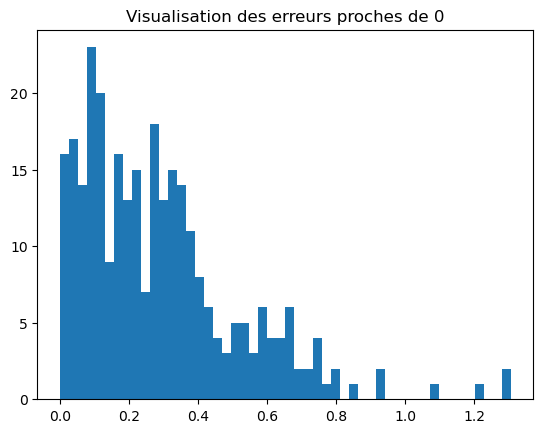

In [46]:
#Visulisation des erreurs (proches de 0 et éloignés)
err_hist=np.abs(y_test-y_pred)
plt.title("Visualisation des erreurs proches de 0")
plt.hist(err_hist, bins=50)
plt.show()

In [47]:
#Mise en place du test de shapiro-wild pour vérifier si les résidus suivent ou non une loi normale
from scipy.stats import shapiro
stat, p_value = shapiro(residus)
print(f"Statistique de test = {stat:.3f}")
print(f"p-value = {p_value:.3f}")
if p_value>0.05:
    print("On ne rejette pas H₀, les résidus sont compatibles avec une loi normale.")
else : 
    print("On rejette H₀, les résidus s'éloignent de la loi normale.")

Statistique de test = 0.991
p-value = 0.058
On ne rejette pas H₀, les résidus sont compatibles avec une loi normale.


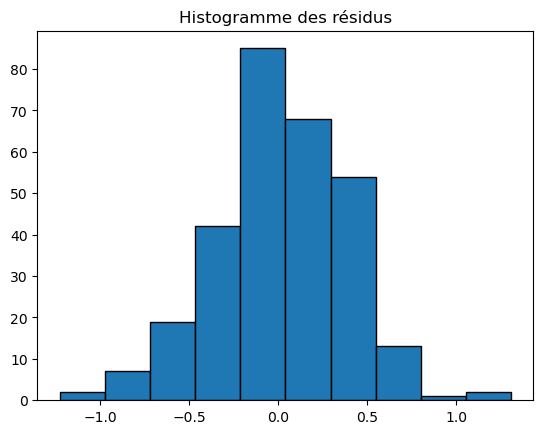

In [48]:
#Représentation graphique des résidus
plt.hist(residus, bins=10, edgecolor='black')
plt.title("Histogramme des résidus")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.7 - Test de homoscédasticité</h3>
</div>

In [49]:
def Test_Hypothese(p_value):
    """ Objectif tester l'hypothèse au regard de la p_value
    Exemple : Test_Hypothese(p_value)"""
    if p_value>0.05:
        return ("Hypothèse nulle (H₀) n'est pas rejetée(Homoscédasticité)")
    else:
        return ("Hypothèse nulle rejetée, il faut considérer l'hypothese alternative(hétéroscédasticité)")    
    

In [50]:
#Test de Breusch–Pagan pour vérifier l'Homoscedasticité
import statsmodels.api as sm
import statsmodels.stats.api as sms

lm = sm.OLS(y, sm.add_constant(X)).fit()
test = sms.het_breuschpagan(lm.resid, lm.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
resultat = (dict(zip(labels, test)))
print(dict(zip(labels, test)))

{'Lagrange multiplier statistic': 165.81873103787407, 'p-value': 3.4639579716065444e-33, 'f-value': 31.020089246318193, 'f p-value': 3.2339734221010783e-35}


In [51]:
Test_Hypothese(resultat['p-value'])

"Hypothèse nulle rejetée, il faut considérer l'hypothese alternative(hétéroscédasticité)"

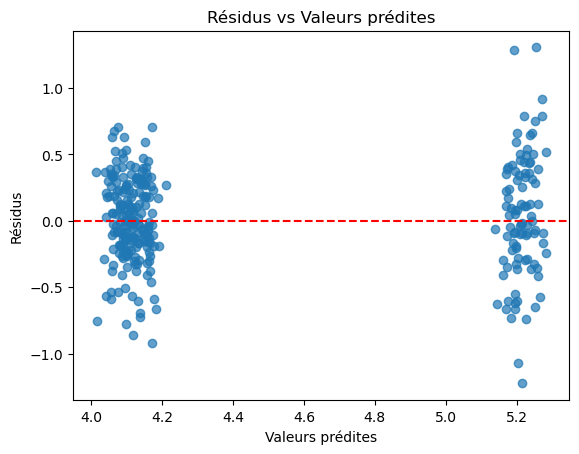

In [52]:
plt.scatter(y_pred,residus, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs prédites")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.5 - Remplacement des valeurs manquantes</h3>
</div>

In [53]:
#Création dataframe récup avec les valeurs NA
Récup=df_margin_low_NA[df_margin_low_NA["margin_low"].isna()]

In [54]:
#retrait du True_BankNote retiré lors du test de colinéarité
Récup.drop(["True_BankNote"],axis=1, inplace= True)

In [55]:
Récup.head(3)

,diagonal,height_left,height_right,margin_low,margin_up,length,Fake_BankNote
72,171.94,103.89,103.45,NaN,3.25,112.79,0.0
99,171.93,104.07,104.18,NaN,3.14,113.08,0.0
151,172.07,103.80,104.38,NaN,3.02,112.93,0.0


In [56]:
# listing des index des NA
missing_idx=Récup.index

In [57]:
#Reprise des données manquantes
Récup = Récup.drop(["margin_low"],axis=1)

In [58]:
#Prédiction des valeurs marginlow en NA
y_NA = regMarLow.predict(Récup)

In [59]:
#Injection des valeurs manquantes dans le dataframe (df) au regard des indexs manquants
df_final.loc[missing_idx, 'margin_low'] = y_NA

In [60]:
#Consultation des valeurs remplacées dans le dataFrame "df_final"  pour ne pas corrompre df qui sera utilisé ultérieurement
df_final.loc[missing_idx].head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.069384,3.25,112.79
99,True,171.93,104.07,104.18,4.103364,3.14,113.08
151,True,172.07,103.80,104.38,4.130311,3.02,112.93
197,True,171.45,103.66,103.80,3.993962,3.62,113.27
241,True,171.83,104.14,104.06,4.127607,3.02,112.36


In [61]:
df_final.shape

(1500, 7)

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Mise en place de la regression logistique Faux billets vs Vrais billets</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Importation des librairies scikitlearn de régression Logistique et de traitements</h3>
</div>

In [62]:
#importation des bibliothèques :
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [63]:
#Initialisation de l'instance de conversion des labels True / False
is_genuine_enc=LabelEncoder()

In [64]:
#Conversion des valeurs booléen False/True en valeur numérique
df["is_genuine"]=is_genuine_enc.fit_transform(df["is_genuine"])

In [65]:
#Retrait des valeurs null du DataFrame
df=df[~df["margin_low"].isnull()]

In [66]:
#Alimentation des features X, retrait Genuine et mise en array
X=(df.drop(['is_genuine'], axis=1)).values

In [67]:
#Alimentation de la target y
y=df["is_genuine"].values

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 - Mise en place du jeu d'entrainement</h3>
</div>

In [68]:
#Mise en place d'un jeu d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.2), random_state=42)

In [69]:
#Initialisation et entrainement de l'instance de régression Logistique
Log_alg = LogisticRegression()
Log_alg.fit(X_train, y_train)

LogisticRegression()

In [70]:
#Mise en place des prédicions basés sur les valeurs X_test
y_pred=Log_alg.predict(X_test)

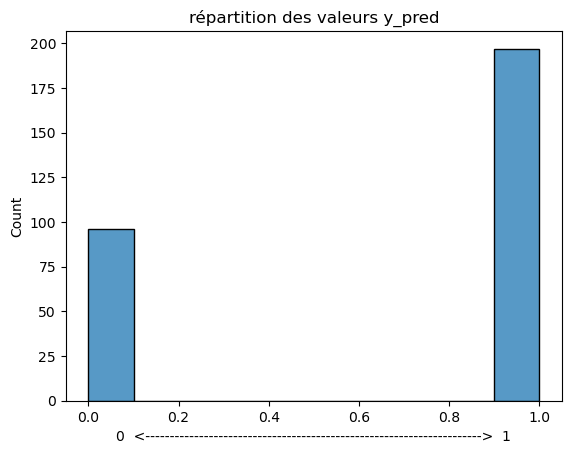

In [71]:
import seaborn as sns
sns.histplot(y_pred)
plt.title("répartition des valeurs y_pred")
plt.xlabel("0  <--------------------------------------------------------------------->  1")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.3 - Evaluation du modèle de regression Logistique</h3>
</div>

In [72]:
#Identification des Vrai et Faux Positifs et négatifs
confusion_matrix(y_test, y_pred)

array([[ 96,   0],
       [  0, 197]], dtype=int64)

In [73]:
print(f"Vrai négatif (TN) :{confusion_matrix(y_test, y_pred)[1,1]}")
print(f"Faux négatif (FN) :{confusion_matrix(y_test, y_pred)[1,0]}")
print(f"Faux positif (FP) :{confusion_matrix(y_test, y_pred)[0,1]}")
print(f"Vrai positif (TP) :{confusion_matrix(y_test, y_pred)[0,0]}")

Vrai négatif (TN) :197
Faux négatif (FN) :0
Faux positif (FP) :0
Vrai positif (TP) :96


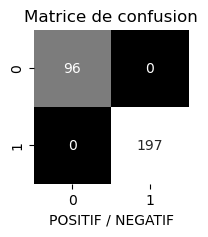

In [74]:
plt.figure(figsize=(2, 2))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", cbar=None, cmap="grey")
plt.title('Matrice de confusion')
plt.xlabel("POSITIF / NEGATIF")
plt.show()

In [75]:
#Calcul de la précision = TP / (TP + FP)
precision_score(y_test, y_pred)

1.0

In [76]:
#Calcul du rappel(recall) = TP / (TP + FN)
recall_score(y_test, y_pred)

1.0

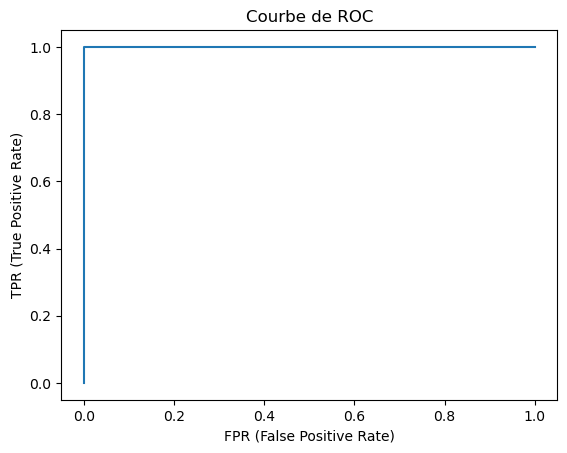

In [77]:
# Mise en place de la courbe obtenue est appelé "Receiver Operating Characteristic" au "ROC"
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

import matplotlib.pyplot as plt
plt.title('Courbe de ROC')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.plot(fpr, tpr)
plt.show()

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Évaluation
print("\nAccuracy :", accuracy_score(y_test, y_pred))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))


Accuracy : 1.0

Matrice de confusion :
 [[ 96   0]
 [  0 197]]

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00       197

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293



<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Intégration d'un nouveau jeu de Production pour valider</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Reprise d'un fichier production</h3>
</div>

In [79]:
df_billet=pd.read_csv("billets_production.csv")

In [80]:
#Retait de la colonne id pour récupération dataframe identique précédent
df_billet_Eval=df_billet.drop(["id"],axis=1)
print(df_billet_Eval)

   diagonal  height_left  height_right  margin_low  margin_up  length
0    171.76       104.01        103.54        5.21       3.30  111.42
1    171.87       104.17        104.13        6.00       3.31  112.09
2    172.00       104.58        104.29        4.99       3.39  111.57
3    172.49       104.55        104.34        4.44       3.03  113.20
4    171.65       103.63        103.56        3.77       3.16  113.33


In [81]:
#S'agit t-il d'un vrai ou faux billet ? Utilisation de la fonction prédict précédement entrainée Log_alg :
is_genuine=Log_alg.predict(df_billet_Eval.values)

In [82]:
is_genuine=pd.DataFrame(is_genuine, columns=["is_genuine"])

In [83]:
is_genuine["is_genuine"]=is_genuine["is_genuine"].replace(0,"Faux_billet")
is_genuine["is_genuine"]=is_genuine["is_genuine"].replace(1,"Vrai_billet")

In [84]:
is_genuine["is_genuine"]

0    Faux_billet
1    Faux_billet
2    Faux_billet
3    Vrai_billet
4    Vrai_billet
Name: is_genuine, dtype: object

In [85]:
Final = pd.concat([is_genuine,df_billet], axis=1)

In [86]:
#Présentation du résultat final
Final

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,Faux_billet,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,Faux_billet,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,Faux_billet,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,Vrai_billet,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,Vrai_billet,171.65,103.63,103.56,3.77,3.16,113.33,A_5


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Test de clustering avec le modèle non supervisé K-Means</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.0 - Préparation des données</h3>
</div>

In [87]:
#Création d'un datafrome "df_K_means" avec retrait des valeurs nulles
df_K_means=df.dropna()

In [88]:
#Transformation des valeurs True et False en 1 et 0 de "isgeniune"
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
df_K_means["is_genuine"]=label_encoder.fit_transform(df_K_means["is_genuine"])

In [89]:
df_K_means.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.1 - Chargement des bibliothèques</h3>
</div>

In [90]:
#Kmeans, mise à l'echelle et silhouette score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.2 - Préparation du modèle</h3>
</div>

In [91]:
X=df_K_means.values

In [92]:
#Mise à l'échelle des données avec MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [93]:
#Initialisation et entrainement du k-means sur 2 groupes (vrais ou faux billets)
k_means = KMeans( n_clusters=2, random_state = 42)
k_means.fit(X_scaled)
print(k_means.cluster_centers_)

[[ 1.00000000e+00  4.81459796e-01  4.66482001e-01  4.40732215e-01
   2.89820614e-01  4.77160835e-01  7.68749214e-01]
 [-1.66533454e-15  4.37260121e-01  6.02607233e-01  6.04545273e-01
   5.70391571e-01  6.59453698e-01  4.43501826e-01]]


  File "C:\Users\ramat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ramat\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ramat\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ramat\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


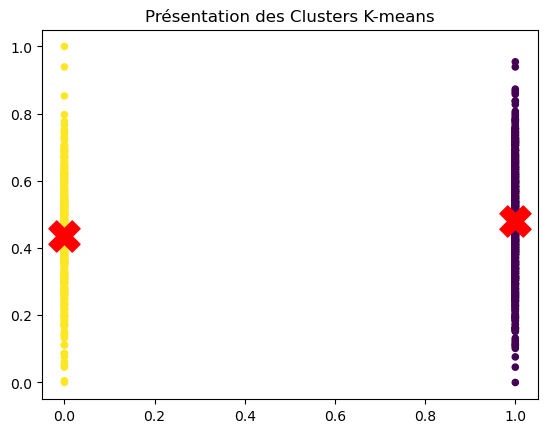

In [94]:
#Représentation graphique du K-means
labels = k_means.labels_  # labels des clusters (1 ou 0)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=20)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c='red', marker='X', s=500)  # centres des clusters
plt.title('Présentation des Clusters K-means')
plt.show()

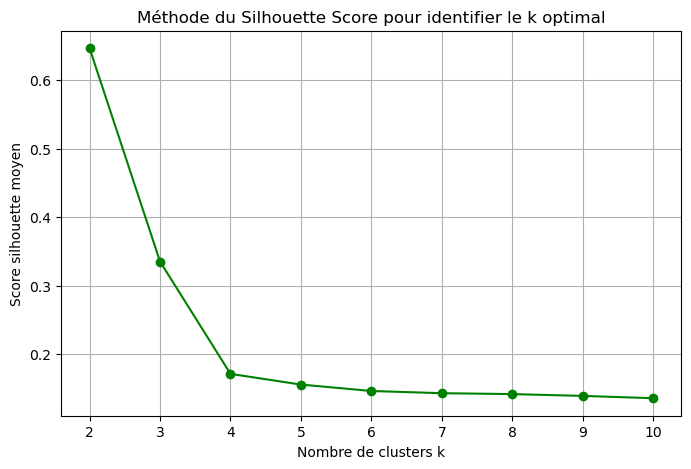

In [95]:
#Controle du nombre de cluster optimum
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Tracer la courbe
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Score silhouette moyen')
plt.title('Méthode du Silhouette Score pour identifier le k optimal')
plt.grid(True)
plt.show()

In [96]:
#Evaluation du modèle: Très bon à 1 et mauvais à 0
from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled, k_means.labels_)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.65


In [97]:
from sklearn.metrics import adjusted_rand_score
y_true = df_K_means["is_genuine"]
ari = adjusted_rand_score(y_true, k_means.labels_)
print(f"Adjusted Rand Index: {ari:.2f}")

Adjusted Rand Index: 1.00


In [98]:
#Analyse par rapport à la colonne is_genuine vs appartenance par cluster
pd.crosstab(k_means.labels_, df_K_means["is_genuine"])

is_genuine,0,1
row_0,,
0,0,971
1,492,0


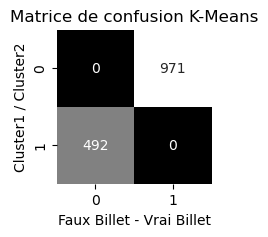

In [99]:
plt.figure(figsize=(2, 2))
sns.heatmap((pd.crosstab(k_means.labels_, df_K_means["is_genuine"])), annot=True, fmt=".0f", cbar=None, cmap="grey")
plt.title('Matrice de confusion K-Means')
plt.xlabel("Faux Billet - Vrai Billet")
plt.ylabel("Cluster1 / Cluster2")
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 6 - Test de classification avec le modèle supervisé KNN</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.0 - Préparation des données</h3>
</div>

In [100]:
#Création d'un datafrome "df_KNN" avec retrait des valeurs nulles
df_KNN=df.dropna()

In [101]:
#Transformation des valeurs True et False en 1 et 0 de "isgeniune"
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
df_KNN["is_genuine"]=label_encoder.fit_transform(df_KNN["is_genuine"])

In [102]:
df_KNN.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.1 - Chargement des bibliothèques</h3>
</div>

In [103]:
#Bibliothèque Kmeans et silhouette pour confirmer le nombre de cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.2 - Préparation du modèle</h3>
</div>

In [104]:
X = df_KNN.drop("is_genuine", axis=1)
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)
y = df["is_genuine"]

In [105]:
#Mise en place d'un jeu de test et d'entrainement.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.3 - Evaluation du modèle</h3>
</div>

In [107]:
y_pred = knn.predict(X_test)

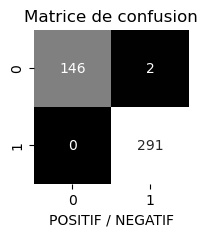

In [108]:
plt.figure(figsize=(2, 2))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", cbar=None, cmap="grey")
plt.title('Matrice de confusion')
plt.xlabel("POSITIF / NEGATIF")
plt.show()

In [109]:
print(f"Matrice de Confusion : \n {confusion_matrix(y_test, y_pred)}")
print()
print(f"Rapport de classification : \n {classification_report(y_test, y_pred)}")

Matrice de Confusion : 
 [[146   2]
 [  0 291]]

Rapport de classification : 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       148
           1       0.99      1.00      1.00       291

    accuracy                           1.00       439
   macro avg       1.00      0.99      0.99       439
weighted avg       1.00      1.00      1.00       439



<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 7 - Test de classification avec le modèle supervisé Random Forest (Classification)</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">7.0 - Préparation des données</h3>
</div>

In [110]:
#Création d'un datafrome "df_RandomF" avec retrait des valeurs nulles
df_RandomF=df.dropna()

In [111]:
#Transformation des valeurs True et False en 1 et 0 de "isgeniune"
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
df_RandomF["is_genuine"]=label_encoder.fit_transform(df_RandomF["is_genuine"])

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">7.1 - Chargement des bibliothèques</h3>
</div>

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">7.2 - Préparation du modèles</h3>
</div>

In [113]:
X = df_RandomF.drop("is_genuine", axis=1)
y = df_RandomF["is_genuine"]
nom_colonnes=X.columns

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [115]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [116]:
rf.feature_importances_

array([0.01097311, 0.03646805, 0.04543866, 0.3249452 , 0.10863461,
       0.47354036])

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">7.3 - Evaluation du modèles</h3>
</div>

In [117]:
y_pred = rf.predict(X_test)

In [118]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print(f"Matrice de Confusion : \n {confusion_matrix(y_test, y_pred)}")
print()
print(f"Rapport de classification : \n {classification_report(y_test, y_pred)}")

Accuracy : 0.9931662870159453
Matrice de Confusion : 
 [[146   2]
 [  1 290]]

Rapport de classification : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       148
           1       0.99      1.00      0.99       291

    accuracy                           0.99       439
   macro avg       0.99      0.99      0.99       439
weighted avg       0.99      0.99      0.99       439



In [119]:
rf.score(X_test,y_test)

0.9931662870159453

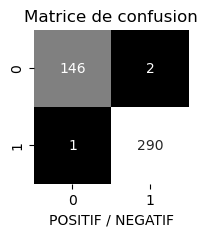

In [122]:
plt.figure(figsize=(2, 2))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", cbar=None, cmap="grey")
plt.title('Matrice de confusion')
plt.xlabel("POSITIF / NEGATIF")
plt.show()

In [120]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[146   2]
 [  1 290]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       148
           1       0.99      1.00      0.99       291

    accuracy                           0.99       439
   macro avg       0.99      0.99      0.99       439
weighted avg       0.99      0.99      0.99       439



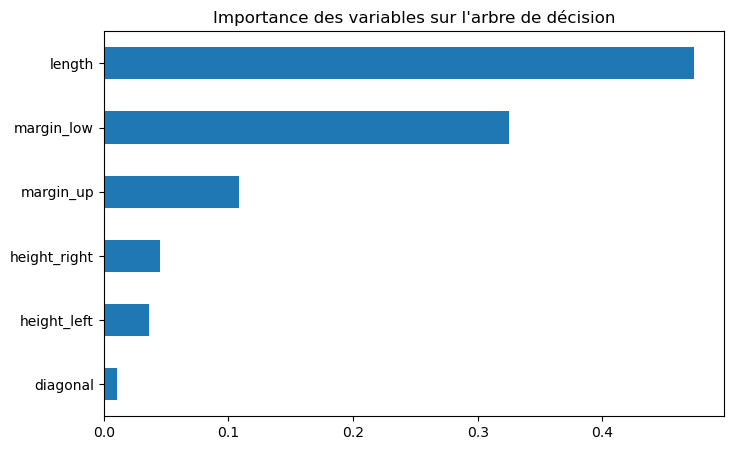

In [121]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(8,5), title="Importance des variables sur l'arbre de décision")
plt.show()